In [13]:
using JuMP, Gurobi, Mosek, PyPlot

    k = 4              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 50
    T[4] = 60

    # define waypoints
    xw = [ 0   1   6   7
           0   0   0   0]

mass = 1000 # in kg
g = 127008  #km/hr^2
maxacc = 500 # max acc in km/hr^2
maxv = 200 # max velocity in km/hr
maxTu = 1.27 #max steer one side
Friction = 5;

function solveOpt(λ)
    # m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, p[1:2,1:T[k]])
    @variable(m, 0 <= Thrust[1:T[k]] <= maxacc)
    @variable(m, 0 <= Braking[1:T[k]] <= maxacc)
    
    @variable(m, 0 <= v[1:2,1:T[k]] <= maxv) 
#     @variable(m, AccDm[1:k]) #final magnitude of acceleration in direction of motion
    @variable(m, Acc[1:2,1:k]) #Acc[1,T] is the direction of motion

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== 0)
    @constraint(m, v[:,60] .== 0)
#     @constraint(m, Acc[1,:] == Thrust[t] - Braking[t] - Frction)
#     @constraint(m, p[:,T[1]] .== xw[:,1])
#     @constraint(m, p[:,T[2]] .== xw[:,2])

    for t in 1:T[k]-1
        @constraint(m, p[1,t+1] == p[1,t] + v[1,t])
        @constraint(m, p[2,t+1] == p[2,t] + v[2,t])
        @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * cos(atan(v[2,t]/v[1,t])
        @constraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * sin(atan(v[2,t]/v[1,t])
        @constraint(m, Acc[1,t+1] == Acc[1,t] + Thrust[t] - Braking[t] - Frction)
    end
    
    # hit all the waypoints
    for i in 1:2
        @constraint(m, p[:,T[i]] .== xw[:,i])
    end
    
    
    # hit the first waypoint only
#     for i in 1
#         @constraint(m, p[:,T[i]] .== xw[:,1])
#     end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min,sum(Thrust.^2))# + λ*sum( (p[:,T]-xw).^2 ) )
    solve(m)
    
    J1 = getvalue(sum(Thrust.^2))
    J2 = getvalue(sum( (p[:,T]-xw).^2  ))
    xopt = getvalue(p)
    
    
    th = getvalue(Thrust)
    Vel = getvalue(v)
    for t in 1:T[k]
        println(t, ": Thrust = ", th[t], "| Velocity x= ", Vel[1,t], "| Velocity y= ", Vel[2,t])
    end
println(xopt[1,20], " : ", xopt[2,20])
figure(figsize=(12,4))
plot( th[2,:], "b.-", markersize=4 )
plot( Vel[2,:], "r-", markersize=12 )
plot( th[1,:], "m.-", markersize=4 )
plot( Vel[1,:], "g-", markersize=12 )
# axis("equal")
axis((1.,60.1,-.00005,.11));
    
    
    return (J1,J2,xopt)
end
;

LoadError: [91msyntax: missing comma or ) in argument list[39m

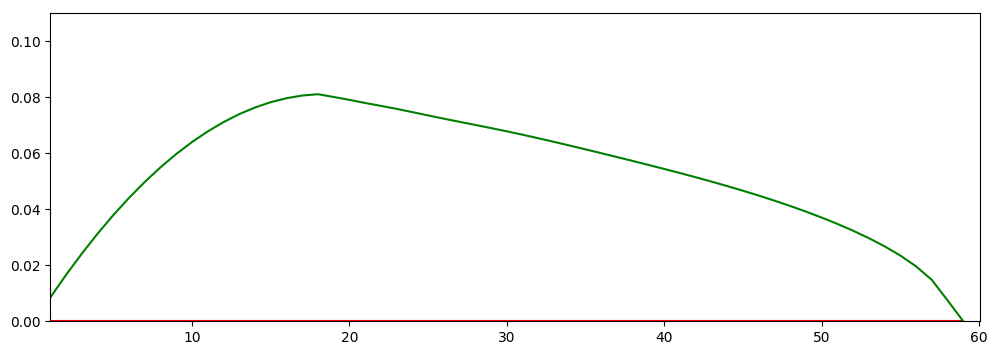

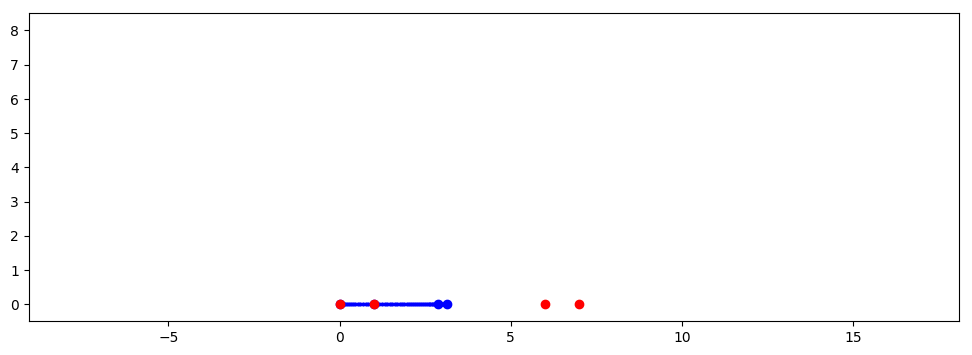

1: Thrust = 0.008534871171090126| Velocity x= 0.0| Velocity y= 0.0
2: Thrust = 0.008060711600514369| Velocity x= 0.008534863124127679| Velocity y= 0.0
3: Thrust = 0.007586552116221268| Velocity x= 0.016595565846751696| Velocity y= -0.0
4: Thrust = 0.007112392680879088| Velocity x= 0.02418210849436688| Velocity y= 0.0
5: Thrust = 0.006638233264725208| Velocity x= 0.03129449129171253| Velocity y= 0.0
6: Thrust = 0.006164073845836557| Velocity x= 0.03793271438718525| Velocity y= 0.0
7: Thrust = 0.005689914415089007| Velocity x= 0.04409677769866671| Velocity y= 0.0
8: Thrust = 0.005215754981307821| Velocity x= 0.049786680709666735| Velocity y= 0.0
9: Thrust = 0.004741595566289482| Velocity x= 0.05500242277974949| Velocity y= 0.0
10: Thrust = 0.004267436193799043| Velocity x= 0.0597440035871344| Velocity y= 0.0
11: Thrust = 0.003793276869632614| Velocity x= 0.06401142341850277| Velocity y= 0.0
12: Thrust = 0.003319117593857693| Velocity x= 0.06780468292182099| Velocity y= 0.0
13: Thrust = 0

In [14]:
λ = 0.001
(J1x,J2x,x) = solveOpt(λ)

using PyPlot
figure(figsize=(12,4))
plot( x[1,:], x[2,:], "b.-", markersize=4 )
plot( x[1,:][T], x[2,:][T], "b.", markersize=12 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
axis("equal")
axis((1.,8.,-.5,8.5));